In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import link
import network
import path 
import mode
import path2link
import ride_hailing

In [2]:
# read data
my_link = pd.read_excel('../input_network/Nguyen_Dupuis_network.xlsx', sheet_name='link_info')
my_link['I'] = 0
my_node = pd.read_excel('../input_network/Nguyen_Dupuis_network.xlsx', sheet_name='node_info')
my_link['name'] = my_link['from'].astype('str') +'-'+ my_link['to'].astype('str')
my_demand = pd.read_excel('../input_network/Nguyen_Dupuis_network.xlsx', sheet_name='demand_info')
print(my_demand)

  OD_pair  demand
0   r1-s1    5000
1   r1-s2    5000
2   r2-s1    5000
3   r2-s2    5000


In [3]:
# set parameter
origin_zone = ['r1','r2']
destination_zone = ['s1','s2']
theta_1 = 0.08# path
theta_2 = 0.05 # mode
miu_in = 20
miu_out = 15
lamda_0_hailing = 2
lamda_0_PR = 15
lamda_0_transit=3
N_hailing = 500

In [4]:
def MSA_assignment():
    
    # 0. generate path set
    my_network = network.get_graph(link_table=my_link, node_table=my_node)
    my_path_set = path.get_path_set(G=my_network, origin_zone=origin_zone, destination_zone=destination_zone)

    # 1. initializing path set
    # 1.1 initializing path cost
    my_path_set = path.get_path_info(path_set=my_path_set, link_table=my_link)
    my_path_set = path.path_cost(path_set=my_path_set,miu_in=miu_in, miu_out=miu_out, lamda_0_transit=lamda_0_transit, theta_1=theta_1)
    # initializing path flow
    my_path_set['path_flow'] = my_demand['demand'].sum() / len(my_path_set) # average assignment
    my_path_set['I'] = 0 # add initial iteration number

    # 1.2 generate mode set
    my_mode_set = mode.get_mode_set(paths=my_path_set,theta_1=theta_1,theta_2=theta_2)
    my_mode_set['I'] = 0 # add initial iteration number
    # print(my_mode_set['mode_logit'].sum())

    # 1.3 get demand-based flow
    new_paths = mode.get_y_flow(mode_set=my_mode_set, path_set=my_path_set,demand=my_demand)
    new_paths['I'] = 0 # add initial iteration number
    new_paths['path_flow'] = my_path_set['path_flow']

    ######################################################################################
    # iteration
    from sklearn.metrics import mean_squared_error
    import numpy as np

    maximum_iter = 1000
    acceptable_gap = 0.01
    
    # 1. initialize a list to store the result of each iteration
    iteration = []
    res_link_flow = my_link.copy()
    res_path_flow = new_paths.copy()
    res_path_set = my_path_set.copy()
    res_mode_set = my_mode_set.copy()
    idle_ride_hailing = [[0, N_hailing]]

    for I in range(1, maximum_iter+1):
        # 2.1 cheak the convergence
        MSE = mean_squared_error(new_paths['path_flow'].values, new_paths['y_flow'].values)
        RMSE = np.sqrt(MSE)
        print('Iteration = {0}, gap = {1},'.format(I,RMSE))

        if RMSE < acceptable_gap:
            break

        # 2.2 update path flow
        new_paths['path_flow'] = new_paths['path_flow'] + (1 / I) * (new_paths['y_flow'] - new_paths['path_flow'])
        path_flow = new_paths['path_flow'].values

        # 2.3 update link flow
        my_link_set = path2link.update_link_flow(path_set=new_paths, link_table=my_link)

        # 2.4 compute idle ride-hailing vehicle number
        n_idle_hailing = ride_hailing.compute_idle_vehile(link_table=my_link,N_hailing=N_hailing)
        print(f'the number of idle_hailing:{n_idle_hailing}')

        # 2.5 update link cost
        my_link_set = link.compute_link_time(link_table=my_link_set,
                        n_idle=n_idle_hailing,
                        lamda_0_auto=link.compute_lamda_0_auto(),
                        lamda_0_hailing=lamda_0_hailing,
                        lamda_0_PR=lamda_0_PR,
                        miu_out=miu_out)
        my_link_set['I'] = I # add iteration number in link_set
        # record wait time

        # 2.6 re-compute path information
        my_path_set = path.get_path_info(path_set=my_path_set, link_table=my_link_set)
        my_path_set = path.path_cost(path_set=my_path_set,miu_in=miu_in, miu_out=miu_out, lamda_0_transit=lamda_0_transit, theta_1=theta_1)
        my_path_set['I'] = I # add initial iteration number

        # 2.8 re-generate mode set
        my_mode_set = mode.get_mode_set(paths=my_path_set, theta_1=theta_1,theta_2=theta_2)
        my_mode_set['I'] = I # add iteration number in mode_set
        #print(my_mode_set['mode_logit'].sum())

        # 2.9 re-generate y_flow
        new_paths = mode.get_y_flow(mode_set=my_mode_set,path_set=my_path_set, demand=my_demand)
        new_paths['path_flow'] = path_flow # Update path flow for the next iteration based on MSA updating method 
        new_paths['I'] = I # add iteration number

        # 2.13 store the result of each iteration
            # 2.13.1 iteration number and gap
        iteration.append([I, RMSE])
            # 2.13.2 link_set
        res_link_flow = pd.concat([res_link_flow, my_link_set], ignore_index=True)
            # 2.13.3 path_set
        res_path_set = pd.concat([res_path_set, my_path_set], ignore_index=True)
        res_path_flow = pd.concat([res_path_flow, new_paths], ignore_index=True)
            # 2.13.4 mode_set
        res_mode_set = pd.concat([res_mode_set, my_mode_set], ignore_index=True)
            # 2.13.5 n_idle
        idle_ride_hailing.append([I, n_idle_hailing])

        # 3. transform the iteration to dataframe
    iteration = pd.DataFrame(iteration, columns=['I', 'RMSE'])
    idle_ride_hailing = pd.DataFrame(idle_ride_hailing, columns=['I', 'n_idle'])
    idle_ride_hailing['wait_time'] = idle_ride_hailing['n_idle'].apply(lambda x: (2 / (1 + x**0.5)) * 60)

    return iteration, res_link_flow, res_path_flow, res_path_set, res_mode_set, idle_ride_hailing

In [5]:
res = MSA_assignment()

Iteration = 1, gap = 259.0877418528443,
the number of idle_hailing:452.02654614211815
Iteration = 2, gap = 139.5571711431463,
the number of idle_hailing:206.48372952678585
Iteration = 3, gap = 144.6477892498477,
the number of idle_hailing:167.5372159079031
Iteration = 4, gap = 102.80550426739235,
the number of idle_hailing:154.18981549467338
Iteration = 5, gap = 71.75248548124634,
the number of idle_hailing:148.6687125025997
Iteration = 6, gap = 59.684923152731336,
the number of idle_hailing:145.97081841493713
Iteration = 7, gap = 60.06501828834434,
the number of idle_hailing:145.1684846291272
Iteration = 8, gap = 54.28520253175057,
the number of idle_hailing:145.64745730131875
Iteration = 9, gap = 55.10462645941303,
the number of idle_hailing:146.4473926068468
Iteration = 10, gap = 51.21130182597415,
the number of idle_hailing:147.47448578217393
Iteration = 11, gap = 50.94792646184012,
the number of idle_hailing:148.45030157519875
Iteration = 12, gap = 48.32432670332219,
the number of

In [6]:
# RMSE
RMSE = res[0]

# idle ride-hailing vehicle number
ride_hailing = res[5]

# market share
mode = res[4]

In [7]:
import matplotlib.pyplot as plt
import numpy as np

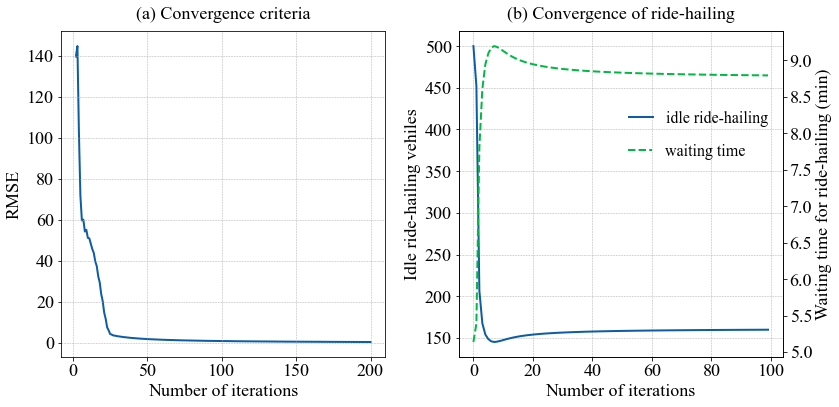

In [8]:
num_loc = 200
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18

fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(1,2,1)
ax1.grid(ls = '--', lw = 0.5, zorder = 0)
ax1.plot(RMSE['I'].iloc[1:num_loc], RMSE['RMSE'].iloc[1:num_loc], '-', lw = 2, color='#0c5DA5', label='RMSE', markersize=5, zorder =1)
#ax1.set_xticks(np.arange(5, 105, 10))
#ax1.set_xlim(0, 101)
#ax1.set_yticks(np.arange(0, 0.55, 0.05))
#ax1.set_ylim(0, 0.5)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('RMSE')
ax1.set_title('(a) Convergence criteria', fontsize=18, loc = 'center', y=1.02)

ax2 = plt.subplot(1,2,2)
ax2.grid(ls = '--', lw = 0.5)
ax2.plot(ride_hailing['I'].iloc[:100], ride_hailing['n_idle'].iloc[:100], '-', lw = 2, color='#0c5DA5', label='idle ride-hailing', markersize=5)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Idle ride-hailing vehiles')
# ax2.set_xticks(np.arange(5, 31, 5))
# ax2.set_xlim(0.5, 30.5)
# ax2.set_yticks(np.arange(155,210, 5))
# ax2.set_ylim(150,205)
ax2.set_title('(b) Convergence of ride-hailing', fontsize=18, y= 1.02)

ax3 = plt.twinx(ax2)
ax3.plot(ride_hailing['I'].iloc[:100], ride_hailing['wait_time'].iloc[:100], '--', lw = 2, color='#00B945', label='waiting time', markersize=4)
# ax3.set_yticks(np.arange(3.9, 4.7, 0.1))
# ax3.set_ylim(3.8,4.6)
ax3.set_ylabel('Waiting time for ride-hailing (min)')

ax2.legend(loc='best', fontsize=16, frameon=False, handlelength=1.5, bbox_to_anchor=(1, 0.8))
ax3.legend(loc='best', fontsize=16, frameon=False, handlelength=1.5, bbox_to_anchor=(0.93, 0.7))

plt.tight_layout()

plt.show()

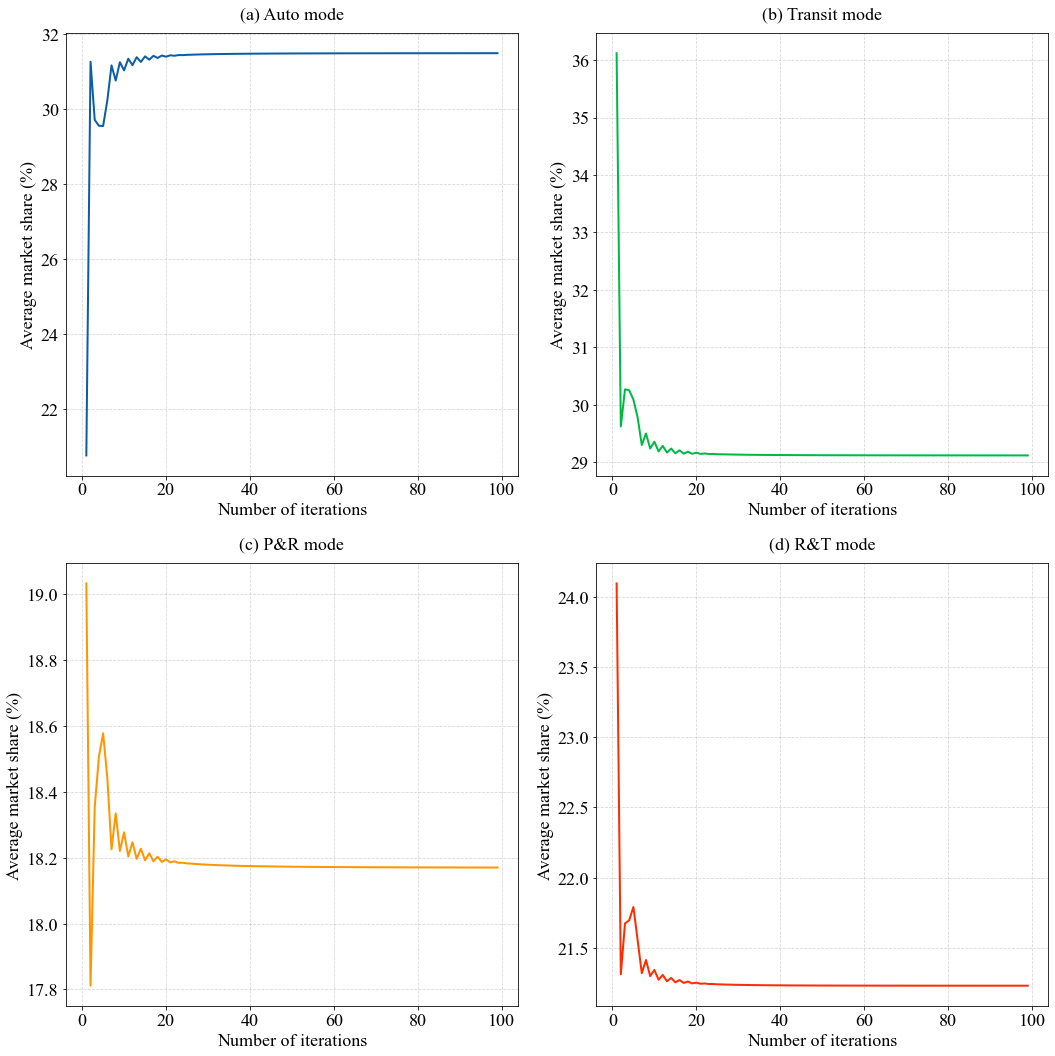

In [9]:
# market share
num_loc = 100
#plt.ticklabel_format(style='plain')

fig,ax = plt.subplots(2,2, figsize=(15,15))
ax = ax.flatten()

ax1 = ax[0]
ax1.ticklabel_format(useOffset=False)
ax1.grid(ls='--', alpha = 0.5)
ax1.plot(mode[mode['mode'] == 'auto'].iloc[1:num_loc]['I'], 
         mode[mode['mode'] == 'auto'].iloc[1:num_loc]['mode_logit']*100, 
         '-', color='#0c5DA5', label='Auto', markersize=5, lw=2)
# ax1.set_xticks(np.arange(0, 205, 20))
# ax1.set_xlim(0.5, 50.5)
# ax1.set_yticks(np.arange(296.8, 298.4, 0.2))
#ax1.set_ylim(36.125,36.127)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Average market share (%)')
ax1.set_title('(a) Auto mode', fontsize=18, loc='center', y=1.02)

ax2 = ax[1]
ax2.ticklabel_format(useOffset=False)
ax2.grid(ls='--', alpha = 0.5)
ax2.plot(mode[mode['mode'] == 'transit'].iloc[1:num_loc]['I'], 
         mode[mode['mode'] == 'transit'].iloc[1:num_loc]['mode_logit']*100, 
         '-', color='#00b945', label='Transit', markersize=5, lw=2)
# ax1.set_xticks(np.arange(0, 205, 20))
# ax1.set_xlim(0.5, 50.5)
# ax1.set_yticks(np.arange(296.8, 298.4, 0.2))
#ax2.set_ylim(21.2512,21.2518)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Average market share (%)')
ax2.set_title('(b) Transit mode', fontsize=18, loc='center', y=1.02)

ax3 = ax[2]
ax3.ticklabel_format(useOffset=False)
ax3.grid(ls='--', alpha = 0.5)
ax3.plot(mode[mode['mode'] == 'P&R'].iloc[1:num_loc]['I'], 
         mode[mode['mode'] == 'P&R'].iloc[1:num_loc]['mode_logit']*100, 
         '-', color='#ff9500', label='P&R', markersize=5, lw=2)
# ax1.set_xticks(np.arange(0, 205, 20))
# ax1.set_xlim(0.5, 50.5)
# ax1.set_yticks(np.arange(296.8, 298.4, 0.2))
#ax3.set_ylim(19.7795,19.7810)
ax3.set_xlabel('Number of iterations')
ax3.set_ylabel('Average market share (%)')
ax3.set_title('(c) P&R mode', fontsize=18, loc='center', y=1.02)

ax4 = ax[3]
ax4.ticklabel_format(useOffset=False)
ax4.grid(ls='--', alpha = 0.5)
ax4.plot(mode[mode['mode'] == 'R&T'].iloc[1:num_loc]['I'], 
         mode[mode['mode'] == 'R&T'].iloc[1:num_loc]['mode_logit']*100, 
         '-', color='#ff2c00', label='R&T', markersize=5, lw=2)
# ax1.set_xticks(np.arange(0, 205, 20))
# ax1.set_xlim(0.5, 50.5)
# ax1.set_yticks(np.arange(296.8, 298.4, 0.2))
#ax4.set_ylim(22.8405,22.8440)
ax4.set_xlabel('Number of iterations')
ax4.set_ylabel('Average market share (%)')
ax4.set_title('(d) R&T mode', fontsize=18, loc='center', y=1.02)

plt.tight_layout()

plt.show()

In [10]:
mode[mode['mode'] == 'R&T'].iloc[1:num_loc]['mode_logit']*100

5      24.096012
9      21.311035
13     21.673457
17     21.696039
21     21.790738
         ...    
381    21.229719
385    21.229717
389    21.229716
393    21.229715
397    21.229714
Name: mode_logit, Length: 99, dtype: float64

In [11]:
link=res[1]

In [12]:
link[link['link_id'] == 2].head(20)

,link_id,from,to,type,attribute,c_a,l_a,f_bus,t_0,travel,fare_rate,walk,wait,congestion,penalty,flow,I,name
1,2,N4,N1,physical,auto,200,3.0,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0,0.000000,0,N4-N1
54,2,N4,N1,physical,auto,200,3.0,0,3.0,83.386552,41.693276,0.0,0.0,0.0,0,731.177329,1,N4-N1
107,2,N4,N1,physical,auto,200,3.0,0,3.0,8.024159,4.012080,0.0,0.0,0.0,0,365.588664,2,N4-N1
160,2,N4,N1,physical,auto,200,3.0,0,3.0,4.364622,2.182311,0.0,0.0,0.0,0,263.924651,3,N4-N1
213,2,N4,N1,physical,auto,200,3.0,0,3.0,3.885005,1.942502,0.0,0.0,0.0,0,236.844493,4,N4-N1
266,2,N4,N1,physical,auto,200,3.0,0,3.0,3.385241,1.692621,0.0,0.0,0.0,0,192.380048,5,N4-N1
319,2,N4,N1,physical,auto,200,3.0,0,3.0,3.280422,1.640211,0.0,0.0,0.0,0,177.696865,6,N4-N1
372,2,N4,N1,physical,auto,200,3.0,0,3.0,3.186697,1.593348,0.0,0.0,0.0,0,160.513319,7,N4-N1
425,2,N4,N1,physical,auto,200,3.0,0,3.0,3.184608,1.592304,0.0,0.0,0.0,0,160.062495,8,N4-N1
478,2,N4,N1,physical,auto,200,3.0,0,3.0,3.139315,1.569657,0.0,0.0,0.0,0,149.185290,9,N4-N1


In [13]:
path = res[2]

In [14]:
path[path['path_id'] == 'path-4']

,OD_pair,demand,path_id,name_sque,attribute_set,path_length,path_duration,path_cost,mode,mode_logit,mode_flow,path_logit,y_flow,I,path_flow
3,r1-s1,5000,path-4,"[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N9, N9-...","[board_auto, auto, alight_auto]",21.0,0.000000,-0.000000,auto,0.551663,2758.314228,3.030303e-02,8.358528e+01,0,344.827586
61,r1-s1,5000,path-4,"[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N9, N9-...","[board_auto, auto, alight_auto]",21.0,1280.621214,-1067.184345,auto,0.207521,1037.604555,5.617744e-37,5.828997e-34,1,83.585280
119,r1-s1,5000,path-4,"[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N9, N9-...","[board_auto, auto, alight_auto]",21.0,102.388075,-85.323396,auto,0.312551,1562.753684,7.429134e-04,1.160991e+00,2,41.792640
177,r1-s1,5000,path-4,"[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N9, N9-...","[board_auto, auto, alight_auto]",21.0,71.177113,-59.314261,auto,0.297048,1485.238137,7.491390e-03,1.112650e+01,3,28.248757
235,r1-s1,5000,path-4,"[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N9, N9-...","[board_auto, auto, alight_auto]",21.0,130.285095,-108.570913,auto,0.295465,1477.327115,1.516773e-04,2.240769e-01,4,23.968192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57771,r1-s1,5000,path-4,"[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N9, N9-...","[board_auto, auto, alight_auto]",21.0,73.039713,-60.866428,auto,0.314839,1574.195701,5.446122e-03,8.573262e+00,996,8.608298
57829,r1-s1,5000,path-4,"[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N9, N9-...","[board_auto, auto, alight_auto]",21.0,73.039711,-60.866426,auto,0.314839,1574.195693,5.446123e-03,8.573263e+00,997,8.608263
57887,r1-s1,5000,path-4,"[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N9, N9-...","[board_auto, auto, alight_auto]",21.0,73.039709,-60.866424,auto,0.314839,1574.195685,5.446124e-03,8.573264e+00,998,8.608228
57945,r1-s1,5000,path-4,"[r1-N3, N3-N4, N4-N1, N1-N2, N2-N5, N5-N9, N9-...","[board_auto, auto, alight_auto]",21.0,73.039707,-60.866422,auto,0.314839,1574.195677,5.446124e-03,8.573266e+00,999,8.608193


In [15]:
ride_hailing

,I,n_idle,wait_time
0,0,500.000000,5.136837
1,1,452.026546,5.390614
2,2,206.483730,7.807650
3,3,167.537216,8.606088
4,4,154.189815,8.943664
...,...,...,...
996,996,161.220354,8.760878
997,997,161.220492,8.760874
998,998,161.220631,8.760871
999,999,161.220769,8.760867
